In [23]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import wget
import dask
import os
from tqdm import tqdm
%matplotlib inline

## Download k-line spot data by every minute from binance

In [24]:
url_template = r"https://data.binance.vision/data/spot/daily/klines/{0}/1h/{0}-1h-{1}.zip"
dir_template = r"data/spot/daily/klines/{0}/1h/{0}-1h-{1}.zip"


# @dask.delayed
def download_one_date(url, path):
    try:
        tmp = wget.download(url, out=path)
        return True
    except:
        # print("{} download failed".format(url))
        return False

def download_all_dates(token_pair: str, dates, path):
    first_meet = False
    for each in dates:
        res = download_one_date(url_template.format(token_pair, str(each.date())), path)
        if first_meet == False and res == True:
            first_meet = True
        if first_meet == True and res == False:
            break
    # promises = [download_one_date(url_template.format(token_pair, str(each.date())), path) for each in dates]
    # alldata=dask.compute(promises) 
    
def get_asset_pairs(x):
    with open("asset_pairs.txt", "r") as f:
        names = f.read()
    names = names.replace("\t", "")
    names = names.replace("\n", "")
    names = names.split("/")
    x_names = list(filter(lambda each: each.endswith(x), names))
    print("x: {} results length: {}".format(x, len(x_names)))
    return x_names
    

In [25]:
@dask.delayed
def main_download(pair, dates):
    path = "data/spot/daily/klines/{0}/1h".format(pair)
    if not os.path.exists(path):
        os.makedirs(path)
    download_all_dates(pair, dates, path)

In [26]:
USDT_pairs = get_asset_pairs("USDT")
BUSD_pairs = get_asset_pairs("BUSD")

x: USDT results length: 394
x: BUSD results length: 350


In [28]:
dates = pd.date_range(start="2021-03-01",end="2023-01-15")
promises = [main_download(each, dates) for each in USDT_pairs]
dask.compute(promises)
# for i in tqdm(range(len(USDT_pairs))):
#     main_download(USDT_pairs[i], dates)

## Data loading & pre-processing

In [13]:
@dask.delayed
def process_raw(pair, date):
    names = [
        "Open time",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Close time",
        "Quote asset volume",
        "Number of trades",
        "Taker buy base asset volume",
        "Taker buy quote asset volume",
        "Ignore",
    ]
    btcdata = pd.read_csv(dir_template.format(pair, date), names=names, header=None)
    btcdata["time"] = pd.to_datetime(btcdata["Open time"], unit='ms')
    date_indexed = btcdata.set_index("time")
    date_indexed.drop('Open time', axis=1, inplace=True)
    date_indexed.drop('Close time', axis=1, inplace=True)
    # date_indexed.drop('time', axis=1, inplace=True)

    # date_indexed["s"] = (date_indexed["isBuyerMaker"].astype(int)-0.5)*(-2)
    # date_indexed["mid"] = date_indexed["price"]
    return date_indexed


def load_data():
    pair = "BTCUSDT"
    # dates = list(pd.date_range(start="2021-03-01",end="2021-03-06"))
    dates = list(pd.date_range(start="2023-01-13",end="2023-01-15"))
    tasks = [process_raw(pair, each.date()) for each in dates]
    p_data_arr = dask.compute(tasks)
    return p_data_arr

In [14]:
p_data_arr = load_btc_usdt()

In [16]:
len(p_data_arr[0])
# p_data_arr[0][0]
pd.concat(p_data_arr[0])

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
time,,,,,,,,,,
2023-01-13 00:00:00,18846.62,18887.00,18714.12,18771.61,14571.89741,2.740580e+08,332716,7226.09691,1.358993e+08,0
2023-01-13 01:00:00,18771.61,18819.37,18744.58,18811.48,9450.99789,1.775544e+08,271773,4661.89766,8.758413e+07,0
2023-01-13 02:00:00,18811.40,18842.73,18786.10,18835.48,8659.24400,1.629257e+08,230250,4197.52597,7.897905e+07,0
2023-01-13 03:00:00,18835.48,18883.55,18823.54,18876.37,9046.16516,1.704865e+08,223210,4388.63295,8.271028e+07,0
2023-01-13 04:00:00,18876.37,18883.79,18818.31,18821.27,8211.64506,1.548646e+08,211548,3813.17463,7.191482e+07,0
...,...,...,...,...,...,...,...,...,...,...
2023-01-15 19:00:00,20817.94,20903.47,20776.78,20870.15,5169.47152,1.077948e+08,170274,2634.29357,5.493409e+07,0
2023-01-15 20:00:00,20870.15,20929.99,20836.10,20905.69,5012.86860,1.046544e+08,157033,2472.11906,5.161079e+07,0
2023-01-15 21:00:00,20904.74,20932.40,20860.01,20900.62,4089.65709,8.546228e+07,136510,1943.51712,4.061572e+07,0


## Response function

In [27]:
@dask.delayed
def compute_R(events,tau_max=1000,dtau=1):
    taus=range(1,tau_max,dtau)
    R=[]
    R_plus=[]
    R_minus=[]
    for tau in taus:
        events_mid_shifted=events["mid"].shift(-tau)
        R.append(np.nanmean(events["s"]*(events_mid_shifted-events["mid"])))
    return np.array(R)   

In [29]:
p_data_arr[0]["price"].plot()

TypeError: list indices must be integers or slices, not str

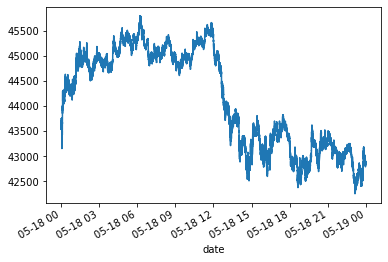

In [20]:
p_data_arr[1]["price"].plot()

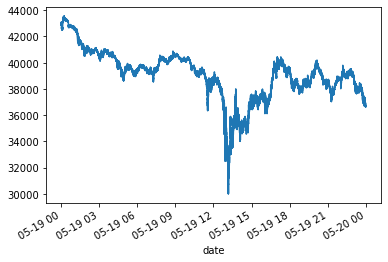

In [21]:
p_data_arr[2]["price"].plot()

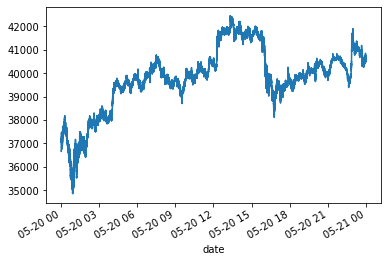

In [22]:
p_data_arr[3]["price"].plot()

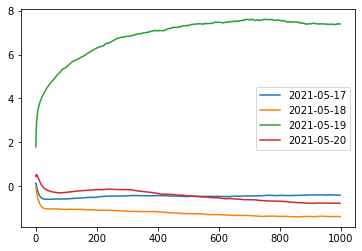

In [16]:
dates = list(pd.date_range(start="2021-05-17",end="2021-05-20"))
tasks = [compute_R(each) for each in p_data_arr]
rsbs_arr = dask.compute(tasks)
for data, date in zip(rsbs_arr, dates):
    plt.plot(data,label=date.date())
plt.legend()
plt.show()

19800

['1INCHBTC',
 '1INCHBUSD',
 '1INCHDOWNUSDT',
 '1INCHUPUSDT',
 '1INCHUSDT',
 'AAVEBNB',
 'AAVEBRL',
 'AAVEBTC',
 'AAVEBUSD',
 'AAVEDOWNUSDT',
 'AAVEETH',
 'AAVEUPUSDT',
 'AAVEUSDT',
 'ACABTC',
 'ACABUSD',
 'ACAUSDT',
 'ACHBTC',
 'ACHBUSD',
 'ACHUSDT',
 'ACMBTC',
 'ACMBUSD',
 'ACMUSDT',
 'ADAAUD',
 'ADABIDR',
 'ADABNB',
 'ADABRL',
 'ADABTC',
 'ADABUSD',
 'ADADOWNUSDT',
 'ADAETH',
 'ADAEUR',
 'ADAGBP',
 'ADARUB',
 'ADATRY',
 'ADATUSD',
 'ADAUPUSDT',
 'ADAUSDC',
 'ADAUSDT',
 'ADXBTC',
 'ADXBUSD',
 'ADXETH',
 'ADXUSDT',
 'AERGOBTC',
 'AERGOBUSD',
 'AGIBTC',
 'AGIXBTC',
 'AGIXBUSD',
 'AGLDBNB',
 'AGLDBTC',
 'AGLDBUSD',
 'AGLDUSDT',
 'AIONBTC',
 'AIONETH',
 'AIONUSDT',
 'AKROBTC',
 'AKROBUSD',
 'AKROUSDT',
 'ALCXBTC',
 'ALCXBUSD',
 'ALCXUSDT',
 'ALGOBIDR',
 'ALGOBNB',
 'ALGOBTC',
 'ALGOBUSD',
 'ALGOETH',
 'ALGORUB',
 'ALGOTRY',
 'ALGOTUSD',
 'ALGOUSDT',
 'ALICEBIDR',
 'ALICEBNB',
 'ALICEBTC',
 'ALICEBUSD',
 'ALICETRY',
 'ALICEUSDT',
 'ALPACABNB',
 'ALPACABTC',
 'ALPACABUSD',
 'ALPACAUSDT',
 '